In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyRegressor
from sklearn.metrics import r2_score
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow_addons.metrics import RSquare
from tensorflow.keras.utils import timeseries_dataset_from_array

In [2]:
df = pd.read_csv('../data/processed_data/data_2.csv')
df.head(3)

,CRASH_DATETIME,CASUALTY,FRONT_OR_BACK_ENDED,GOING_STRAIGHT_AHEAD,IN_INTERSECTION,TRUCK_TAXI_BIKE,CLUSTER
0,2012-07-01 10:40:00,0,0,0,0,0,0
1,2012-07-01 12:18:00,0,0,0,0,1,0
2,2012-07-01 18:00:00,0,0,0,0,0,1


# Preprocessing

In [3]:
df['CRASH_DATETIME'] = pd.to_datetime(df['CRASH_DATETIME'])
df = df.set_index('CRASH_DATETIME').resample('W')[['CASUALTY']].sum()

for i in [*range(1, 3)]:
    df[f"lag_{i}"] = df['CASUALTY'].shift(i)
    
df['time'] = range(df.shape[0])
df['covid'] = df.index.to_series().between('2020-03-01', '2020-07-01').astype(int)
df.dropna(inplace=True)

In [4]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['CASUALTY']), df['CASUALTY'], test_size=0.15, shuffle=False)

sc = StandardScaler()
X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.transform(X_test)

# Baseline

In [5]:
dummy = DummyRegressor()
dummy.fit(X_train_sc, y_train)
r2_score(y_test, dummy.predict(X_test_sc))

-2.049051569388713

### timeseries_dataset_from_array()

In [6]:
seq_length = 2
batch_size = 128

train_gen = timeseries_dataset_from_array(
    data=X_train_sc, 
    targets=y_train, 
    sequence_length=seq_length,
    batch_size=batch_size
)

val_gen = timeseries_dataset_from_array(
    data=X_test_sc,
    targets=y_test,
    sequence_length=seq_length,
    batch_size=batch_size
)

In [7]:
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape=(seq_length, X_train_sc.shape[1])))
model.add(LSTM(32))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 2, 128)            68096     
                                                                 
 lstm_1 (LSTM)               (None, 32)                20608     
                                                                 
 dense (Dense)               (None, 32)                1056      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 89,793
Trainable params: 89,793
Non-trainable params: 0
_________________________________________________________________


In [9]:
# Compile

model.compile(loss='mse', optimizer='rmsprop', metrics=[RSquare()])

In [17]:
early_stopping = EarlyStopping(patience=30, restore_best_weights=True)
check_point = ModelCheckpoint('../data/best_model_2.h5', save_best_only=True)

# Fit
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=200,
    callbacks=[early_stopping, check_point],
    verbose=1
)

Epoch 1/200
4/4 [==============================] - 0s 97ms/step - loss: 577.1337 - r_square: 0.3429 - val_loss: 106.4275 - val_r_square: 0.6558
Epoch 2/200
4/4 [==============================] - 0s 70ms/step - loss: 549.2844 - r_square: 0.3746 - val_loss: 99.9579 - val_r_square: 0.6768
Epoch 3/200
4/4 [==============================] - 0s 48ms/step - loss: 527.7271 - r_square: 0.3992 - val_loss: 119.5608 - val_r_square: 0.6134
Epoch 4/200
4/4 [==============================] - 0s 46ms/step - loss: 509.4910 - r_square: 0.4199 - val_loss: 115.2836 - val_r_square: 0.6272
Epoch 5/200
4/4 [==============================] - 0s 46ms/step - loss: 492.9520 - r_square: 0.4387 - val_loss: 166.1969 - val_r_square: 0.4626
Epoch 6/200
4/4 [==============================] - 0s 44ms/step - loss: 478.8455 - r_square: 0.4548 - val_loss: 143.3041 - val_r_square: 0.5366
Epoch 7/200
4/4 [==============================] - 0s 49ms/step - loss: 464.6550 - r_square: 0.4710 - val_loss: 237.4403 - val_r_square: 

Epoch 58/200
4/4 [==============================] - 0s 52ms/step - loss: 62.5336 - r_square: 0.9288 - val_loss: 27.5998 - val_r_square: 0.9107
Epoch 59/200
4/4 [==============================] - 0s 44ms/step - loss: 56.1335 - r_square: 0.9361 - val_loss: 21.7199 - val_r_square: 0.9298
Epoch 60/200
4/4 [==============================] - 0s 49ms/step - loss: 50.3995 - r_square: 0.9426 - val_loss: 25.3818 - val_r_square: 0.9179
Epoch 61/200
4/4 [==============================] - 0s 49ms/step - loss: 45.1606 - r_square: 0.9486 - val_loss: 21.9475 - val_r_square: 0.9290
Epoch 62/200
4/4 [==============================] - 0s 48ms/step - loss: 40.5781 - r_square: 0.9538 - val_loss: 24.0874 - val_r_square: 0.9221
Epoch 63/200
4/4 [==============================] - 0s 45ms/step - loss: 36.4426 - r_square: 0.9585 - val_loss: 22.6943 - val_r_square: 0.9266
Epoch 64/200
4/4 [==============================] - 0s 49ms/step - loss: 32.7606 - r_square: 0.9627 - val_loss: 23.5021 - val_r_square: 0.9240

## Plot results

In [11]:
mm = load_model('../data/best_model.h5')

In [12]:
preds = mm.predict(np.dstack([X_test_sc]*seq_length).transpose(0, 2, 1), verbose=0).ravel()

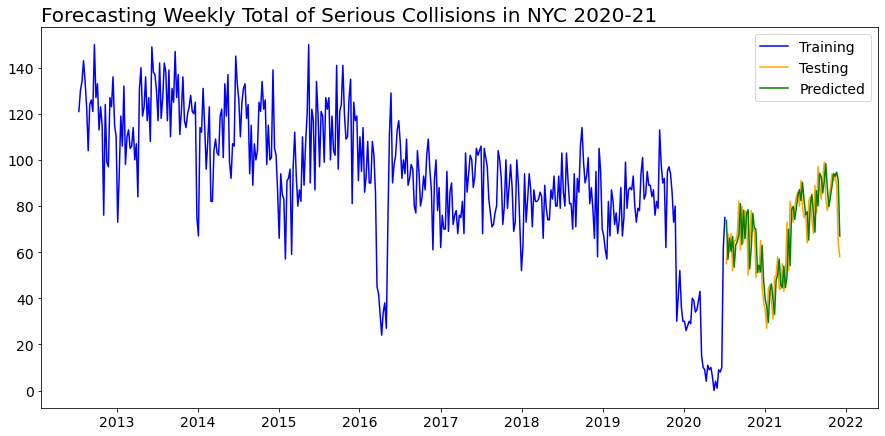

In [14]:
fig, ax = plt.subplots(1, figsize=(15, 7))
ax.plot(y_train, color='blue', label='Training')
ax.plot(y_test, color='orange', label='Testing')
ax.plot(y_test.index, preds, color='green', label='Predicted')
ax.set_title(label = 'Forecasting Weekly Total of Serious Collisions in NYC 2020-21', fontsize=20, loc='left')
ax.tick_params(axis='both', which='major', labelsize=14);
ax.legend(fontsize=14)
fig.savefig('../images/weekly_collisions_forecast_lstm.png', transparent=True, bbox_inches="tight");

# Model Evaluation

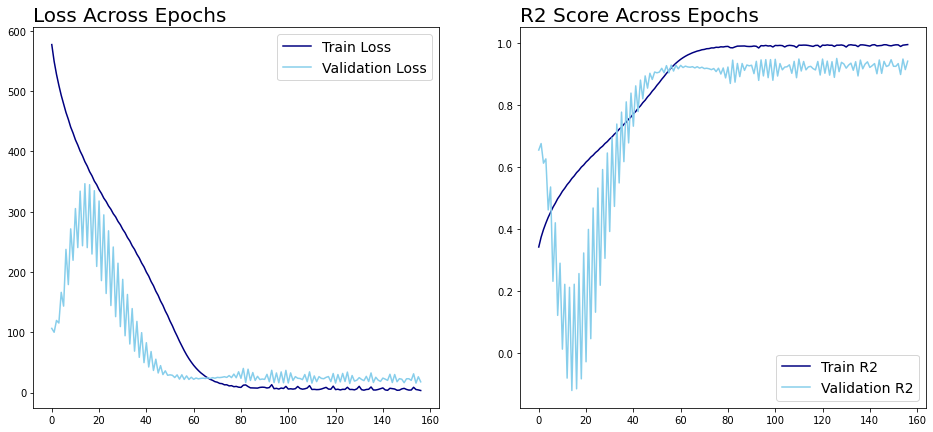

In [20]:
fig, ax = plt.subplots(1, 2, figsize=(16,7))
ax[0].plot(history.history['loss'], c='navy', label='Train Loss')
ax[0].plot(history.history['val_loss'], c='skyblue', label='Validation Loss')
ax[0].legend(fontsize=14)
ax[0].set_title('Loss Across Epochs', fontsize=20, loc='left')

ax[1].plot(history.history['r_square'], c='navy', label='Train R2')
ax[1].plot(history.history['val_r_square'], c='skyblue', label='Validation R2')
ax[1].legend(fontsize=14)
ax[1].set_title('R2 Score Across Epochs', fontsize=20, loc='left')

fig.savefig('../images/lstm_loss.png', transparent=True, bbox_inches="tight");